## U shape PHP dynamics

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using ProgressMeter
using DifferentialEquations

In [3]:
cd(dirname(pwd()))
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing


## Initialization

In [4]:
    ω0 = [sqrt(1.2e004)];
    ℘ = [1.2e005];


    Θ = 0.15;
    θe = 1 + Θ;
    θc = 1 - Θ;
    
    He = 3000.0;
    Hc = 3000.0;


    γ = 1.3;#not 1.4!!!!! maybe 1.33?

In [5]:
    L = 4.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    alpha = pi/2 # inclination angle 

1.5707963267948966

In [6]:
tube = Tube(L,L2D,alpha)

Tube(4.0, 2.0, 1.5707963267948966)

In [7]:
Xe = map(tuple, [0.0; 3.0], [1.0; 4.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)])

In [8]:
Xc = map(tuple, [1.0], [3.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)])

In [9]:
X0 = [(1.5,3.5)]
dXdt0 = [(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)])

In [10]:
P = [1.0,1.0]

vapors=VaporPlug(γ,P)

VaporPlug(1.3, [1.0, 1.0])

In [11]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(4.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 4.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0)]), LiquidSlug(1.3, [109.54451150103323], [120000.0], Tuple{Float64,Float64}[(1.5, 3.5)], Tuple{Float64,Float64}[(0.0, 0.0)]), VaporPlug(1.3, [1.0, 1.0]))

## Get numerical solution

In [12]:
Lvaporplug = XptoLvaporplug(X0,L)
M = P.^(1/γ).* Lvaporplug

u=XMtovec(sys0.liquidslug.Xp,sys0.liquidslug.dXdt,M)

6-element Array{Float64,1}:
 1.5
 3.5
 0.0
 0.0
 1.5
 0.5

In [13]:
tstep=1.0e-5

p = sys0
tspan = (0.0, 0.1);
T = tspan[1]:tstep:tspan[end]

prob = ODEProblem(zhang2002model!, u, tspan, p)
sol = solve(prob, RK4(), adaptive=false, dt=tstep);
integrator = init(prob, RK4(), adaptive =false, dt = tstep, save_everystep=false)

t: 0.0
u: 6-element Array{Float64,1}:
 1.5
 3.5
 0.0
 0.0
 1.5
 0.5

## EnKF construction

In [14]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
#         for j=1:10
        step!(integrator)
#         end
        ENS.S[i] = deepcopy(integrator.u)

    end
    
    return ENS
end

In [15]:
fprop = PropagationFunction()

PropagationFunction()

In [16]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    result=soltoResult(s,sys0);
#     return [s[3]]
    return [result.θ[1],result.θ[2]]
end

In [17]:
function (::MeasurementFunction)(t::Float64) 
#     return reshape([0.0, 0.0, 1.0, 0.0, 0.0, 0.0],(1,6))
    return reshape([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],(2,6))
end

In [18]:
m = MeasurementFunction()

MeasurementFunction()

In [19]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    let s = sol(t)
#     fill!(ENS, [deepcopy(s[3])])
    result=soltoResult(s,sys0);
    fill!(ENS, [deepcopy(result.θ[1]),deepcopy(result.θ[2])])
    end
    return ENS
end

In [20]:
z = RealMeasurementFunction()

RealMeasurementFunction()

In [21]:
# A = MultiAdditiveInflation(2, 1.05, MvNormal(zeros(1), 2.0*I))
A = MultiAdditiveInflation(6, 1.001, MvNormal(zeros(6), 0.001*Diagonal([0.1,0.1,10.0,10.0,0.1,0.1])))
# A = IdentityInflation()

MultiAdditiveInflation{6}(1.001, DiagNormal(
dim: 6
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001]
)
)

In [22]:
# ϵ = AdditiveInflation(MvNormal(zeros(1), 1.0*I))
ϵ = AdditiveInflation(MvNormal(zeros(2), 0.001*Diagonal([0.1,0.1])))

AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.0001 0.0; 0.0 0.0001]
)
)

In [23]:
N = 50
# NZ = 1
NZ = 2
isinflated = true
isfiltered = false
isaugmented = true

true

In [24]:
x₀ = [1.0, 2.0, 0.0, 0.0, 1.0, 1.0]
ens = initialize(N, MvNormal(x₀, 0.001*Diagonal([0.1,0.1,10.0,10.0,0.1,0.1])))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]
covs = []

0-element Array{Any,1}

In [25]:
g = FilteringFunction()

FilteringFunction()

In [26]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,2}(PropagationFunction(), MultiAdditiveInflation{6}(1.001, DiagNormal(
dim: 6
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{2}(DiagNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [0.0001 0.0; 0.0 0.0001]
)
), true, false, true)

## Get EnKF result

In [27]:
Δt = 1e-5
Tsub = 0.0:Δt:0.1-Δt

for (n,t) in enumerate(Tsub)

    global ens
    
    t, ens, cov = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    push!(covs, deepcopy(cov))
    

end

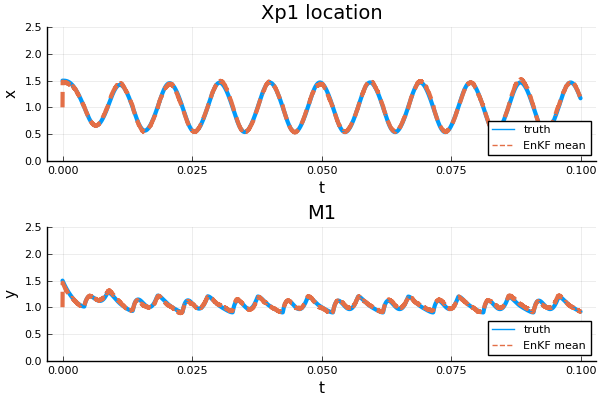

In [28]:
s =  hcat(sol(T).u...)
ŝ =  hcat(mean.(estimation_state)...)

plt = plot(layout = (2, 1), legend = :bottomright)
plot!(plt[1], T, s[1,1:end], linewidth = 3, label = "truth")
plot!(plt[1], Tsub, ŝ[1,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "x", linestyle =:dash,title="Xp1 location",ylim=(0,2.5))

plot!(plt[2], T, s[5,1:end], linewidth = 3, label = "truth")
plot!(plt[2], Tsub, ŝ[5,1:end-1], linewidth = 3, markersize = 2, label = "EnKF mean", xlabel = "t", ylabel = "y", linestyle =:dash,title="M1",ylim=(0,2.5))

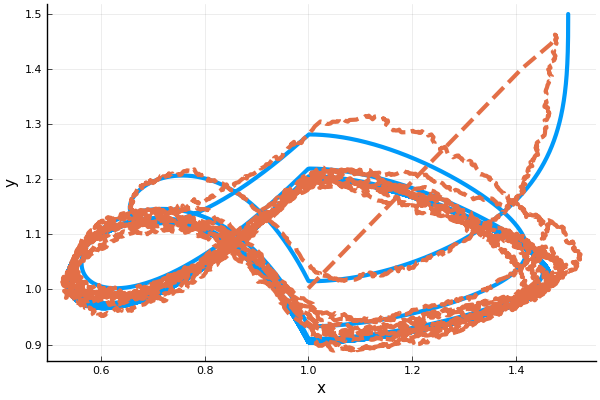

In [29]:
plot(s[1,:], s[5,:], linewidth = 3, label = "truth", legend = true)
plot!(ŝ[1,1:end-1], ŝ[5,1:end-1], linewidth = 3, label = "EnKF mean", xlabel = "x", 
    ylabel = "y", linestyle = :dash, legend = false)#:bottomleft)

In [30]:
mean(abs.((s[1,1:end]-ŝ[1,1:end])./s[1,1:end]))

0.013886605500129061

In [31]:
mean(abs.((s[5,1:end]-ŝ[5,1:end])./s[5,1:end]))

0.01377303632731155

In [32]:
ens.S

50-element Array{Array{Float64,1},1}:
 [1.168302553888813, 3.153530600257608, -262.01533632019, -259.9731579772143, 0.9095018611991081, 1.0645292686373218]      
 [1.2406529364387249, 3.0937207152988564, -260.80905616568765, -259.8358377324558, 0.9840089532664043, 1.1149522136102819] 
 [1.1955825495559942, 3.1385050658743823, -262.92266915424466, -260.00333557116085, 0.9388178721209621, 1.0899428056768408]
 [1.1085038722457976, 3.05444433203579, -261.2250739913841, -257.2402368192582, 0.8968135222598357, 1.2233724404492303]    
 [1.2345236549332643, 3.172613642154083, -263.71796407670064, -260.01675770504124, 0.9776582074064806, 1.0330065486576383] 
 [1.1678483708822427, 3.167807040413845, -262.5759926843254, -258.15445270305986, 0.9375300512249362, 1.088582336901407]   
 [1.207044408029228, 3.165345206489099, -260.9865269131381, -259.2639070892438, 0.9561257687044514, 1.0853372019197705]    
 [1.1482361684520268, 3.08753802159755, -261.0348237592616, -257.50913455962814, 0.86278481762